# solar-data-tools

In [1]:
import utils
import pandas as pd

from bokeh.plotting import figure, show
from bokeh.models import HoverTool
from bokeh.transform import jitter
from bokeh.io import output_notebook

In [2]:
output_notebook()

Loading BokehJS ...

## GitHub

The following plots summarize a subset of all community members that we call "contributors"; it is based on git commit authorship and thus excludes people that file bug reports, contribute to development discussions, and so on.

In [3]:
gh = utils.get_github_stars('slacgismo/solar-data-tools')

In [4]:
p = utils.plot_github_stars_timeseries(gh)
show(p)

In [5]:
forks = utils.get_github_forks('slacgismo/solar-data-tools')
forks = pd.DataFrame({'year': forks.index.year, 'forks': forks})

In [6]:
p = figure(height=350, tooltips=[("Cumulative forks", "@forks"), ("Year", "@year")],
           title="Cumulative forks")
p.vbar(x='year', top='forks', width=0.75, source=forks)
p.yaxis.axis_label = 'Total forks'
show(p)

In [7]:
prs = utils.get_github_pull_requests('slacgismo/solar-data-tools')
prs = pd.DataFrame({'year': prs.index.year, 'prs': prs})

In [8]:
p = figure(height=350, tooltips=[("Cumulative PRs", "@prs"), ("Year", "@year")],
           title="Cumulative PRs")
p.vbar(x='year', top='prs', width=0.75, source=prs)
p.yaxis.axis_label = 'Total PRs'
show(p)

In [9]:
cumulative_contributors, annual_unique_contributors = utils.get_github_contributor_timeseries("slacgismo/solar-data-tools")

In [10]:
p = utils.plot_github_contributors_timeseries(cumulative_contributors)
show(p)

In [11]:
annual_unique_contributors.index = annual_unique_contributors.index.strftime('%Y')
annual_unique_contributors = annual_unique_contributors.reset_index()
annual_unique_contributors.columns = ['year', 'count']

p = figure(x_range=annual_unique_contributors['year'], height=350,
           tooltips=[("Year", "@year"), ("Unique Code Contributors", "@count")],
           title=f"Unique Code Contributors by Year",)
p.vbar(x='year', top='count', width=0.75, source=annual_unique_contributors,
       line_color='white')
p.yaxis.axis_label = 'Unique Code Contributors'
show(p)

In [12]:
contributor_images = utils.get_github_contributors('slacgismo/solar-data-tools')

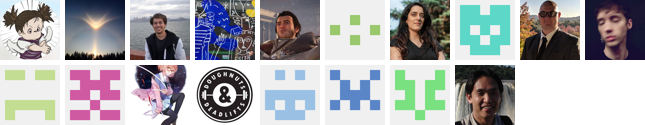

In [13]:
mosaic = utils.make_github_contributors_mosaic(contributor_images)
mosaic